#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 07
**CH07A Finding a Good Deal among Hotels with Simple Regression**

hotels-vienna  dataset

version 1.0 2021-05-05 (modified for TA sessions 04.11.2023)

### Case study description:
In this case study we use simple regression analysis to find a good deal among hotels, i.e. those hotels that are underpriced relative to their distance to the city center. The use of regression analysis is to find what the hotel price "should be" for various levels of distance to the city center, and then compare that price to the actual price of each hotel to identify the especially low value.

### Recap of the theory:

**Regression**: method of comparison

**Simple regression**: comparing conditional means

$E[y|x]=f(x)$ or $y^E=f(x)$

***Non-parametric regression***: describe $y^E=f(x)$ without imposing a specific functional form on $f$. With many values of $x$ (explanatory variable): **bins** and **smoothing**

***Parametric regression*** - **linear**: imposes linearity on $f$ (linearity in terms of the 2 coefficients) 

$y^E=\alpha +\beta x$

## Set up
Packages and data
- os: provides methods for getting directory info, creating and deleting folders, listing files, etc.
- sys: provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter
- numpy: the NumPy library contains multidimensional array and matrix data structures
- pandas: Pandas is the most popular data container in Python for data manipulation and analysis. Pandas has two primary data structures: Series and DataFrames. Series are similar to Python lists or numpy vectors: they are one dimensional. They are more flexible asy can contain mixed types! A Series object also has an index which is printed along the values when it goes toString. Pandas Series are the main building blocks of the Pandas DataFrames.
- mizani.formatters: used to produce stacked bar with percentages (percent format)
- plotnine: chose to import all symbols (functions and variables) in a module to the current namespace, so that we don't need to use the prefix
- statsmodels: usually used to estimate regressions
- warnings: turns off warnings 


In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *       
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore") 

# Current script folder
current_path = os.getcwd()
dirname = current_path.split("TAsessions")[0]

# location folders
data_in = dirname + "TAsessions/da_data_repo/hotels-vienna/clean/"
data_out = dirname + "TAsessions/ch03-hotels-vienna-explore/"
output = dirname + "TAsessions/ch03-hotels-vienna-explore/output/"
func = dirname + "TAsessions/ch00-tech-prep/"
sys.path.append(func)

# Import the prewritten helper functions
from py_helper_functions import *


Extra (from intro_to_regression.ipynb)

- skimpy: use skim for nicer looking descriptive tables

In [2]:
from skimpy import skim

In [3]:
# load vienna
hotels = pd.read_csv(data_in + "hotels-vienna.csv")


### SAMPLE SELECTION

Apply filters:  3-4 stars, Vienna actual, without  extreme value

In [4]:
hotels = hotels.loc[
    (hotels["accommodation_type"] == "Hotel")
    & (hotels["city_actual"] == "Vienna")
    & (hotels["stars"] >= 3)
    & (hotels["stars"] <= 4)
    & (hotels["stars"].notna())
    & (hotels["price"] <= 600)
]

There are two other syntax options for data access:
- .loc[] provides access using the index values
- iloc[] uses the index positions

In [5]:
# save a copy of the work file
hotels.to_csv(data_out + "hotels_work.csv", index=False)


### Summary statistics on price and distance

In [6]:
# Price
hotels[["price"]].describe(percentiles=[0.50, 0.95])
#[[]] to select

,price
count,207.000000
mean,109.975845
std,42.221381
min,50.000000
50%,100.000000
95%,183.400000
max,383.000000


207 observations; 
95th percentile = 5% of the time, the price is above that amount 

In [7]:
# Distance
hotels[["distance"]].describe(percentiles=[0.50, 0.95])


,distance
count,207.000000
mean,1.529952
std,1.161507
min,0.000000
50%,1.300000
95%,3.900000
max,6.600000


In [8]:
## extra
hotels.filter(["price", "distance"]).describe(percentiles=[0.5, 0.95]).T

,count,mean,std,min,50%,95%,max
price,207.0,109.975845,42.221381,50.0,100.0,183.4,383.0
distance,207.0,1.529952,1.161507,0.0,1.3,3.9,6.6


In [9]:
## extra
skim(hotels.filter(["price","distance"]))
#Use skim, from the skimpy package for a nicer looking descriptive tabler

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 207    │ │ int32       │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %    ┃ mean    ┃ sd     ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ price              │    0 │       0 │     110 │     42 │   50 │    82 │   100 │   130 │     380 │   ▇▅▁    │  │
│ │ distance           │    0 │       0 │     1.5 │    1.2 │    0 │   0.8 │   1.3 │   1.9 │     6.6 │   ▇▇▁▂   │  │
│ └────────────────────┴──────┴─────────┴─────────┴────────┴──────┴───────┴───────┴───────┴─────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

# Non-parametric regressions

**Non-parametric regressions**:
- show average of the dependent variable as a function of the explanatory variable $y^E=f(x)$ without imposing a particular functional form
- three most frequent non-parametric regressions show the average of the dependent variable computed
1. for each and every value of x
2. for bins (disjoint intervals) created from x
3. as a smooth curve making use of overlapping intervals of x (lowess)

## REGRESSION 1: CLOSE VS FAR REGRESSION WITH BINARY DISTANCE


**BINS**: disjoint categories that span the entire range of x (many ways to create them)

To learn about the average price of hotels with differing distances to the city center, the simplest comparison is to split the data into two parts (or two bins): one with hotels close and one with hotels further away from the city center. The choice of the distance is arbitrary. We assume that the couple is fine walking 2 miles.

We create a variable dist2 that is equal to 1 if far (distance greater than 2 miles)

In [10]:
hotels["dist2"] = hotels["distance"] >= 2

We group prices by dist2 and get the averages 

In [11]:
hotels["Eprice_cat2"] = hotels.groupby("dist2")["price"].transform("mean") 

We replace the 0 and 1 values with "Close" and "Far", respectively

In [15]:
hotels["dist2"] = hotels["dist2"].replace(False, "Close")
hotels["dist2"] = hotels["dist2"].replace(True, "Far")
#get 2 bins, hotels close and far

Evaluate distance and price grouping by dist2

In [16]:
hotels[["dist2", "distance", "price"]].groupby("dist2").aggregate("describe")


distance                                               price  \
         count      mean       std  min  25%  50%  75%  max  count   
dist2                                                                
Close    157.0  0.994904  0.539325  0.0  0.5  0.9  1.5  1.9  157.0   
Far       50.0  3.210000  0.973789  2.0  2.4  3.1  3.7  6.6   50.0   

                                                                
             mean        std   min    25%    50%    75%    max  
dist2                                                           
Close  116.426752  43.095928  54.0  85.00  109.0  135.0  383.0  
Far     89.720000  32.085371  50.0  74.25   81.5   96.5  208.0

- close bin - 157 hotels, av distance 1 mile, av price 116

- far bin - 50 hotels, av distance 3.2, av price 90

- av difference price -26 (result of the regression analysis)

### Figure 7.1a
### PLOT MEAN VALUES BY CLOSE VS FAR

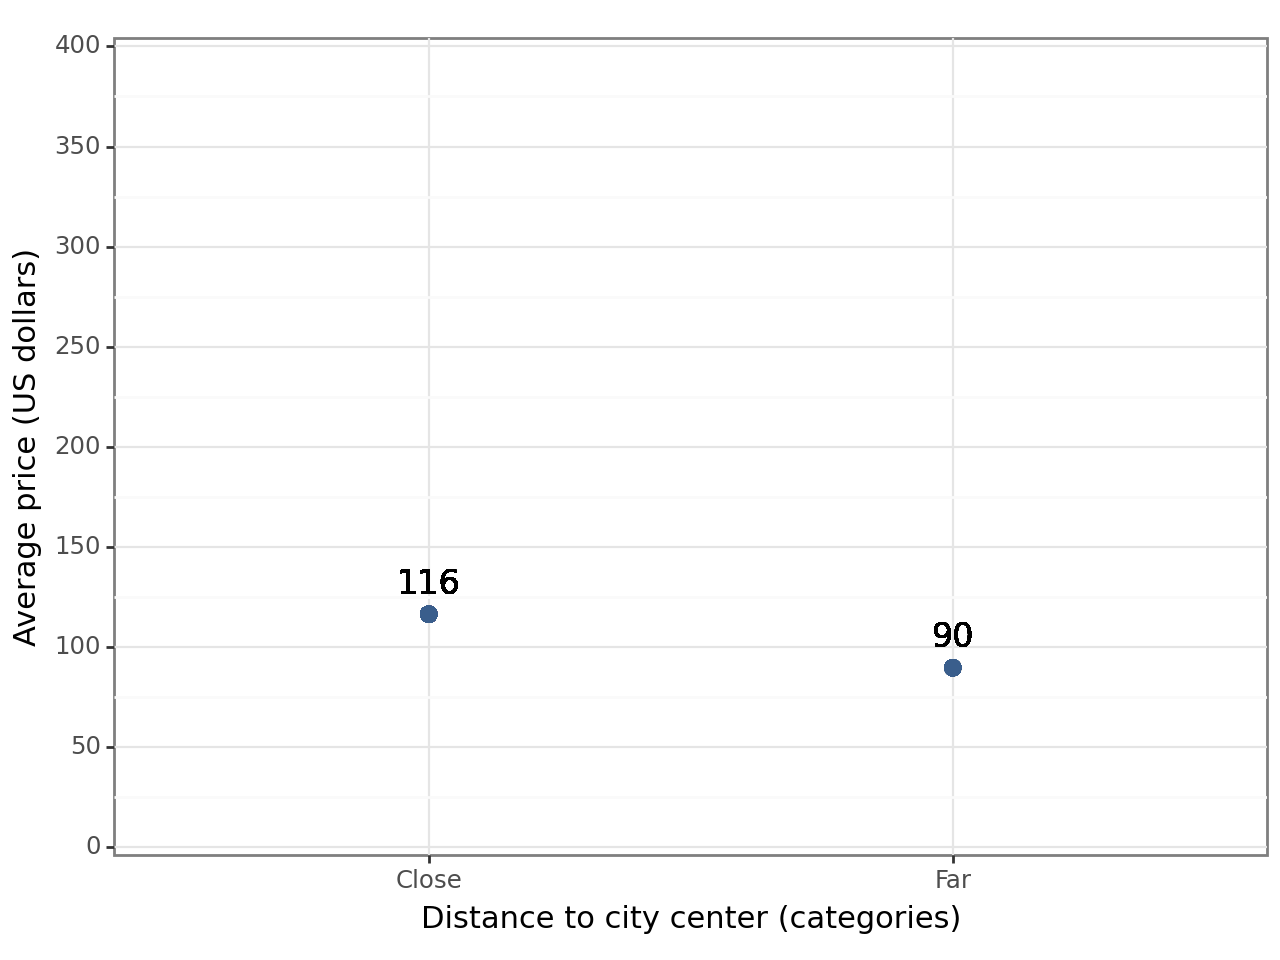

<Figure Size: (640 x 480)>

In [17]:
#geom_point
(
    ggplot(hotels)
    + geom_point(
        aes(x="dist2", y="Eprice_cat2"),
        size=2.5,
        color=color[0],
        fill=color[0],
        alpha=0.4,
    )
    + geom_text(
        aes(
            x="dist2",
            y="[x+15 for x in Eprice_cat2]",
            label=np.round(hotels.Eprice_cat2).apply(int),
        ),
        color="black",
        size=12,
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50)) 
    #seq like np.arrange? returns evenly spaced values within a given interval
    #np.arange(start, stop, step) : Values are generated within the half-open interval 
    #[start, stop), with spacing between values given by step.
    #manipulate the axis
    + expand_limits(y=0.01)
    + scale_x_discrete() #manipulate axis
    + labs(x="Distance to city center (categories)", y="Average price (US dollars)")
    + theme_bw()
)


The x axis has only two points, close and far. We put these two at arbitrary places in terms of the x axis

## REGRESSION 2: 4 bins

We can create more refined bins, splitting both close and far into 2 bins, obtaining 4 bins: [0,1],[1,2],[2,3],[3,7]

In [19]:
hotels["dist4"] = hotels["distance"].apply(
    lambda x: 0.5 #[0,1] (middle of the interval)
    + 1 * int(x >= 1) #[1,2] 
    + 1 * int(x >= 2) #[2,3]
    + 2.5 * int(x >= 3) #[3,7]
)


We compute the mean prices for each group
(below 1, between 1 and 2, between 2 and 3, above 3 -> x value is the midpoint)

In [20]:
hotels["Eprice_cat4"] = hotels.groupby("dist4")["price"].transform("mean") 

In [21]:
hotels[["dist4", "distance", "price"]].groupby("dist4").aggregate("describe")


distance                                                price  \
         count      mean       std  min    25%  50%  75%  max count   
dist4                                                                 
0.5       81.0  0.554321  0.282865  0.0  0.300  0.6  0.8  0.9  81.0   
1.5       76.0  1.464474  0.294258  1.0  1.200  1.5  1.7  1.9  76.0   
2.5       22.0  2.354545  0.318818  2.0  2.100  2.3  2.6  2.9  22.0   
5.0       28.0  3.882143  0.759656  3.0  3.475  3.7  4.1  6.6  28.0   

                                                                  
             mean        std   min     25%    50%     75%    max  
dist4                                                             
0.5    132.913580  38.540627  68.0  110.00  128.0  152.00  242.0  
1.5     98.855263  40.893261  54.0   81.75   91.5  105.25  383.0  
2.5     97.545455  40.385909  54.0   76.25   82.5  100.75  208.0  
5.0     83.571429  22.596998  50.0   68.75   79.0   91.25  156.0

### Fig 7.1b

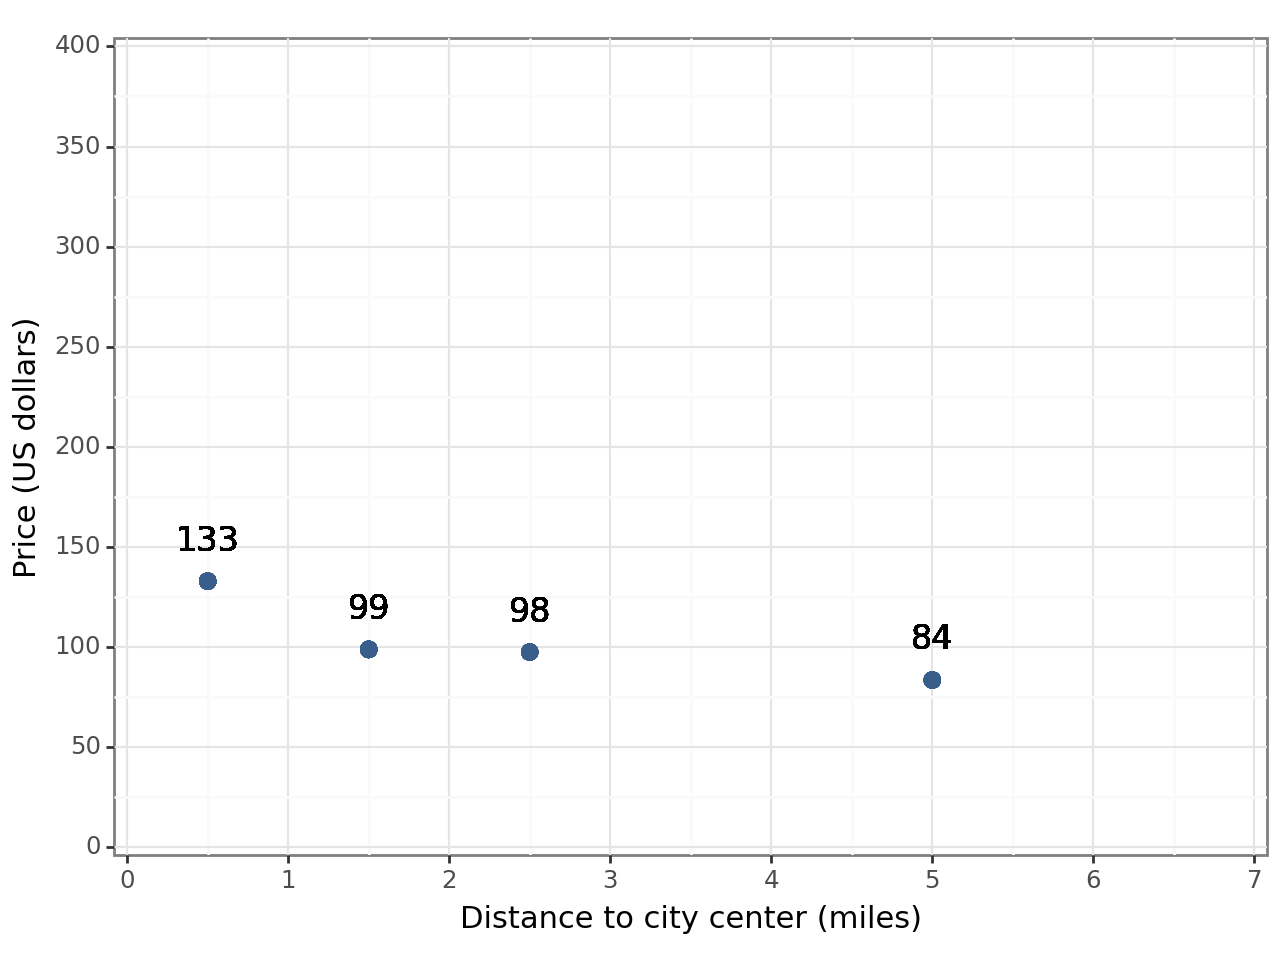

<Figure Size: (640 x 480)>

In [22]:
#geom_point
(
    ggplot(data=hotels)
    + geom_point(
        aes(x="dist4", y="Eprice_cat4"),
        size=2.5,
        color=color[0],
        fill=color[0],
        alpha=0.4,
    )
    + geom_text(
        aes(
            x="dist4",
            y="[x+20 for x in Eprice_cat4]",
            label=np.round(hotels.Eprice_cat4).apply(int),
        ),
        color="black",
        size=12,
    )
    + expand_limits(x=0.01, y=0.01)
    + coord_cartesian(xlim=[0, 7], ylim=[0, 400])
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 401, 50))
    + scale_x_continuous(
        expand=[0.01, 0.01], limits=[0, 7], breaks=[0, 1, 2, 3, 4, 5, 6, 7]
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)


The distance on the x axis is continuous. We put the regression points at specific values of distance within the bins (midpoint of each bin).

Both regressions show that hotels closer to the city center are, **on average**, more expensive.

Thus, they both suggest a **negative** relation between hotel price and distance to the center.

From the second plot, the relationship appears to be monotonic but nonlinear: the differences in average y between the adjacent bins are not always the same (larger negative distance between the first 2 bins)

#### Box-plot
Instead of a simple dot, use a box-plot, which shows the underlying (conditional) distribution better

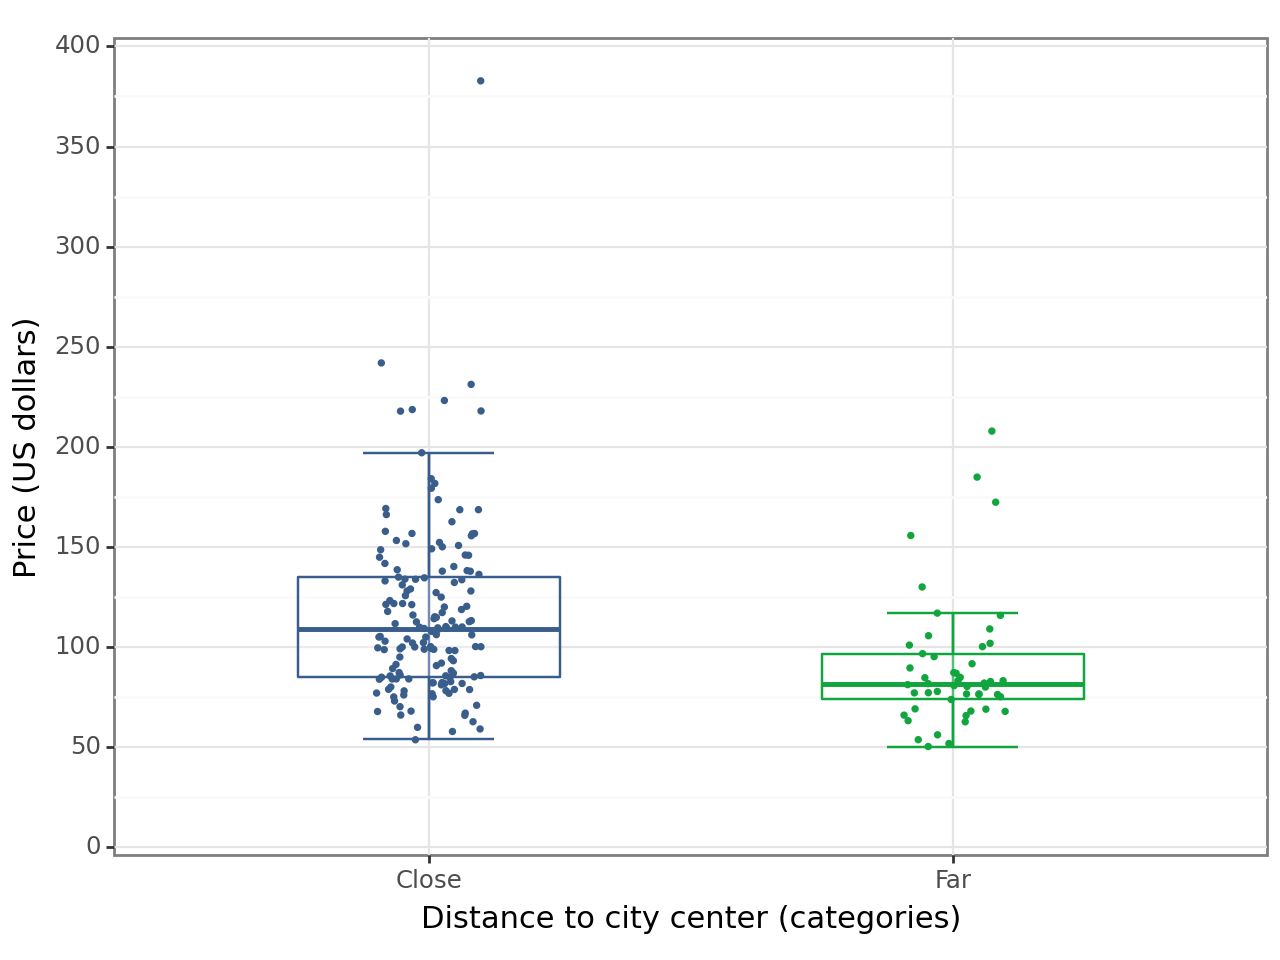

<Figure Size: (640 x 480)>

In [23]:
(
    ggplot(hotels, aes(x="dist2", y="price"))
    + stat_boxplot(
        aes(group="dist2", color="dist2"), geom="errorbar", width=0.25, size=0.5
    )
    + geom_boxplot(
        aes(group="dist2", color="dist2"),
        size=0.5,
        width=0.5,
        alpha=0.3,
        outlier_color="",  # to hide outliers
    )
    + geom_jitter(
        aes(color="dist2"), position=position_jitter(0.1), size=0.5, show_legend=False
    )
    + scale_color_manual(values=[color[0], color[1]], guide=False)
    + labs(x="Distance to city center (categories)", y="Price (US dollars)")
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 401, 50))
    + expand_limits(y=0.01)
    + theme_bw()
)
#not in the book

Box plot:
- thicker middle bar: median (50th percentile)
- upper limit of the box: 75th percentile
- lower limit: 25th percentile
- 75th-25th: interquartile range
- outside-box-bars: upper and lower extremes
- dots outside these extreme bars: outliers


### FIGURE 7.2a 7.2b

First we create the scatterplot between distances and prices

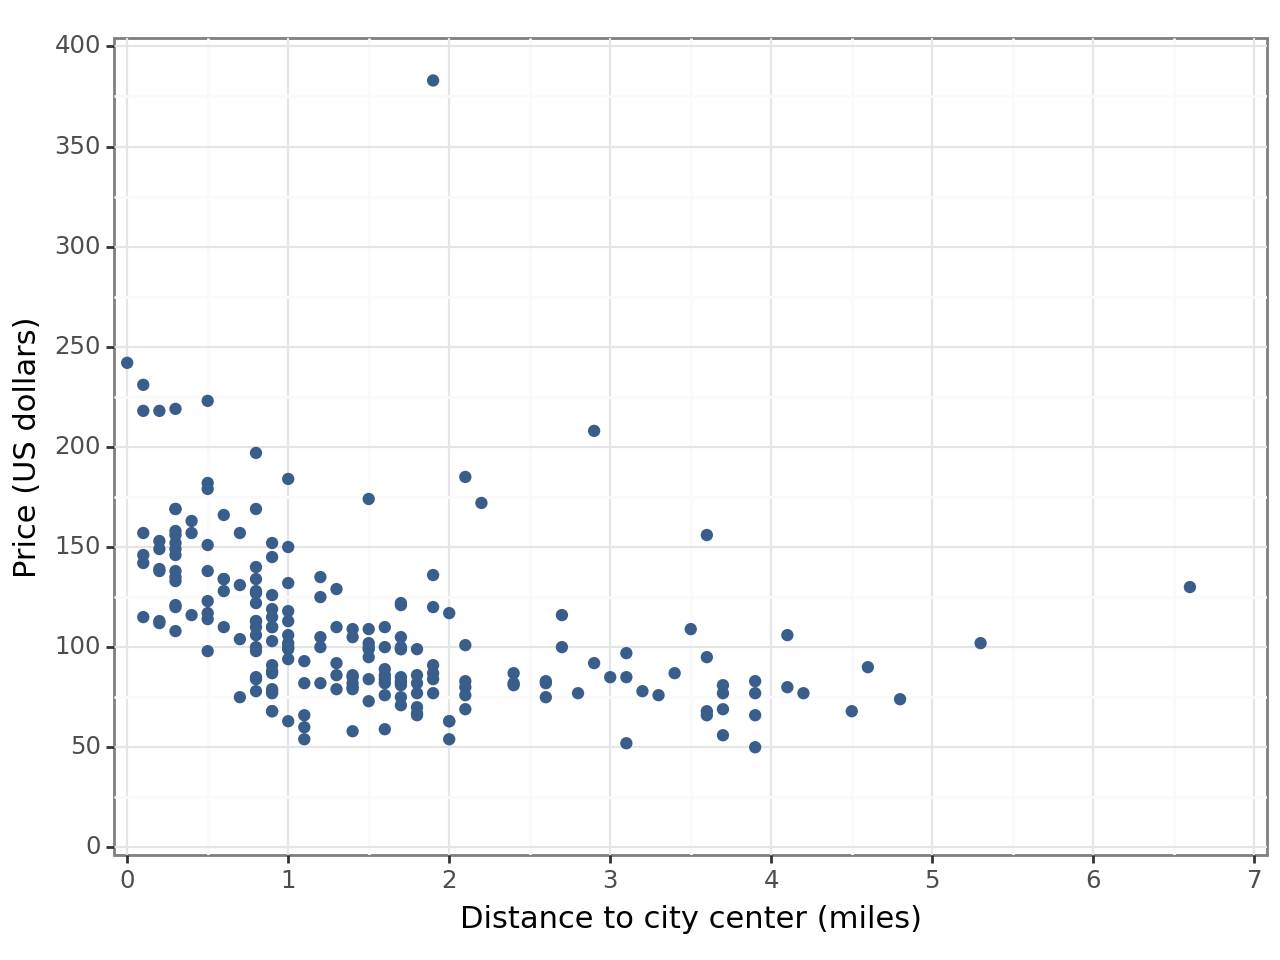

In [24]:
p1 = (
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(color=color[0])
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 7], breaks=seq(0, 7, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50))
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)
print(p1)

#save this scatterplot (to be used in the next graphs)


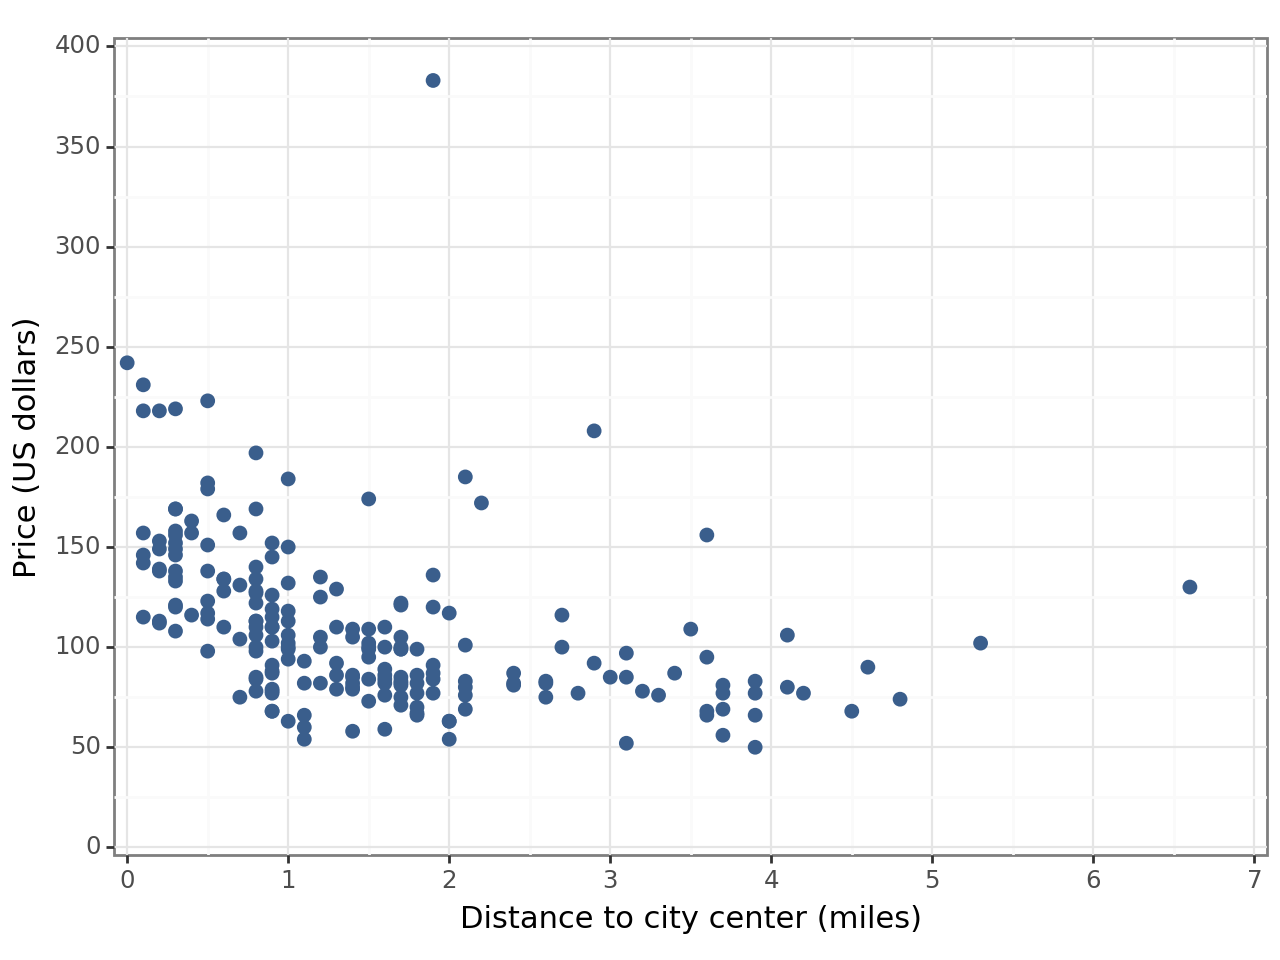

<Figure Size: (640 x 480)>

In [25]:
# large sized graphs
(
    ggplot(hotels)
    + geom_point(
        aes(x="distance", y="price"),
        color=color[0],
        size=2,
        alpha=0.5,
        show_legend=False,
        na_rm=True,
    )
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 7], breaks=seq(0, 7, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50))
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)


#### Scatterplot with step function (we use 1km bits for simpplicity using 4 bits for 3-7km)

In [26]:
hotels["dist4_s"] = hotels["distance"].apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
)
hotels["xend"] = hotels["dist4_s"] + 1 #in which interval of distance
hotels["yend"] = hotels["Eprice_cat4"] #position is the midpoint
#before we had the midpoints
#now 1mile bits

We visualize the 4 bins with a step function: horizontal line segments spanning the entire range of each bin. The figure also include the scatterplot

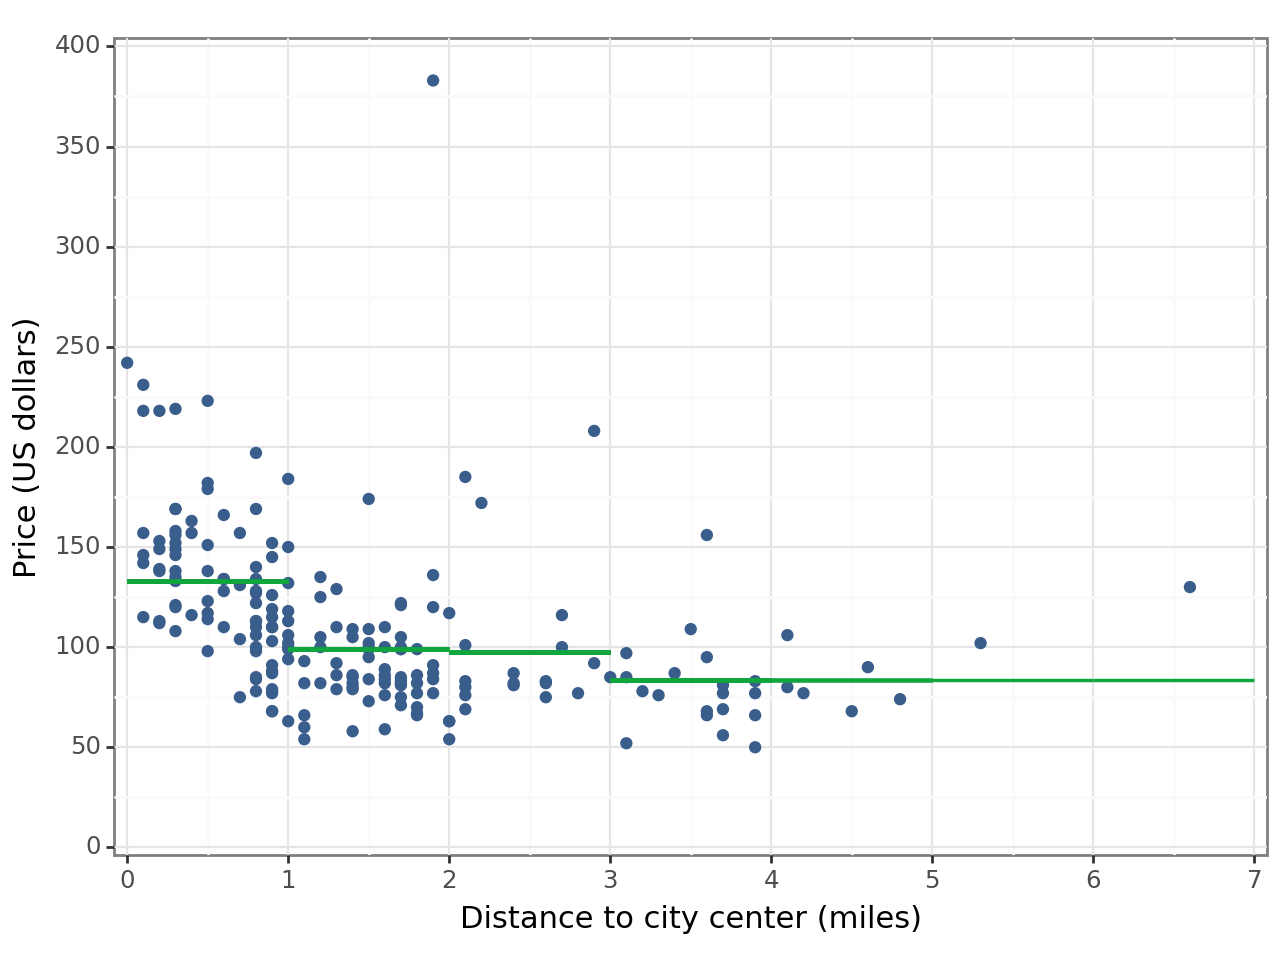

In [27]:
#add geom_segment
F07_2a = p1 + geom_segment(
    hotels,
    aes("dist4_s", "yend", xend="xend", yend="yend"),
    color=color[1],
    size=0.7,
    na_rm=True,
)
print(F07_2a)


The average patterns is **downward sloping** but there is a lot of variation of prices around that average pattern. Also, the scatterplot suggests that the negative pattern my not be valid beyond five miles, although there are only 2 hotels

We consider a non-parametric regression with 7 bins, each of width 1 mile. Use 7 different categories/bins based on distance: below 1, between 1 and 2, 2 and 3, ..., 6 and 7

In [29]:
hotels["dist7_new"] = hotels["distance"].apply(
    lambda x: 0.5 
    + 1 * int(x + 1 >= 1)
    + 1 * int(x + 1 >= 2)
    + 1 * int(x + 1 >= 3)
    + 1 * int(x + 1 >= 4)
    + 1 * int(x + 1 >= 5)
    + 1 * int(x + 1 >= 6)
    + 1 * int(x + 1 >= 7)
)


In [30]:
hotels["Eprice_cat7_new"] = hotels.groupby("dist7_new")["price"].transform("mean")

In [31]:
hotels[["dist7_new", "distance", "price"]].groupby("dist7_new").aggregate("describe")


distance                                                   price  \
             count      mean       std  min    25%   50%    75%  max count   
dist7_new                                                                    
1.5           81.0  0.554321  0.282865  0.0  0.300  0.60  0.800  0.9  81.0   
2.5           76.0  1.464474  0.294258  1.0  1.200  1.50  1.700  1.9  76.0   
3.5           22.0  2.354545  0.318818  2.0  2.100  2.30  2.600  2.9  22.0   
4.5           20.0  3.525000  0.298901  3.0  3.275  3.60  3.700  3.9  20.0   
5.5            6.0  4.383333  0.292689  4.1  4.125  4.35  4.575  4.8   6.0   
6.5            1.0  5.300000       NaN  5.3  5.300  5.30  5.300  5.3   1.0   
7.5            1.0  6.600000       NaN  6.6  6.600  6.60  6.600  6.6   1.0   

                                                                       
                 mean        std    min     25%    50%     75%    max  
dist7_new                                                              
1.5        132.913580  38.540627   68.0  110.00  128.0  152.00  242.0  
2.5         98.855263  40.893261   54.0   81.75   91.5  105.25  383.0  
3.5         97.545455  40.385909   54.0   76.25   82.5  100.75  208.0  
4.5         80.650000  23.154572   50.0   67.50   77.5   85.50  156.0  
5.5         82.500000  13.619838   68.0   74.75   78.5   87.50  106.0  
6.5        102.000000        NaN  102.0  102.00  102.0  102.00  102.0  
7.5        130.000000        NaN  130.0  130.00  130.0  130.00  130.0

In [32]:
# Scatterplot with step function, starting point is simply at cut-off
hotels["dist7_s"] = hotels.distance.apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
    + 1 * int(x >= 7)
)
hotels["xend"] = hotels["dist7_s"] + 1
hotels["yend"] = hotels["Eprice_cat7_new"]


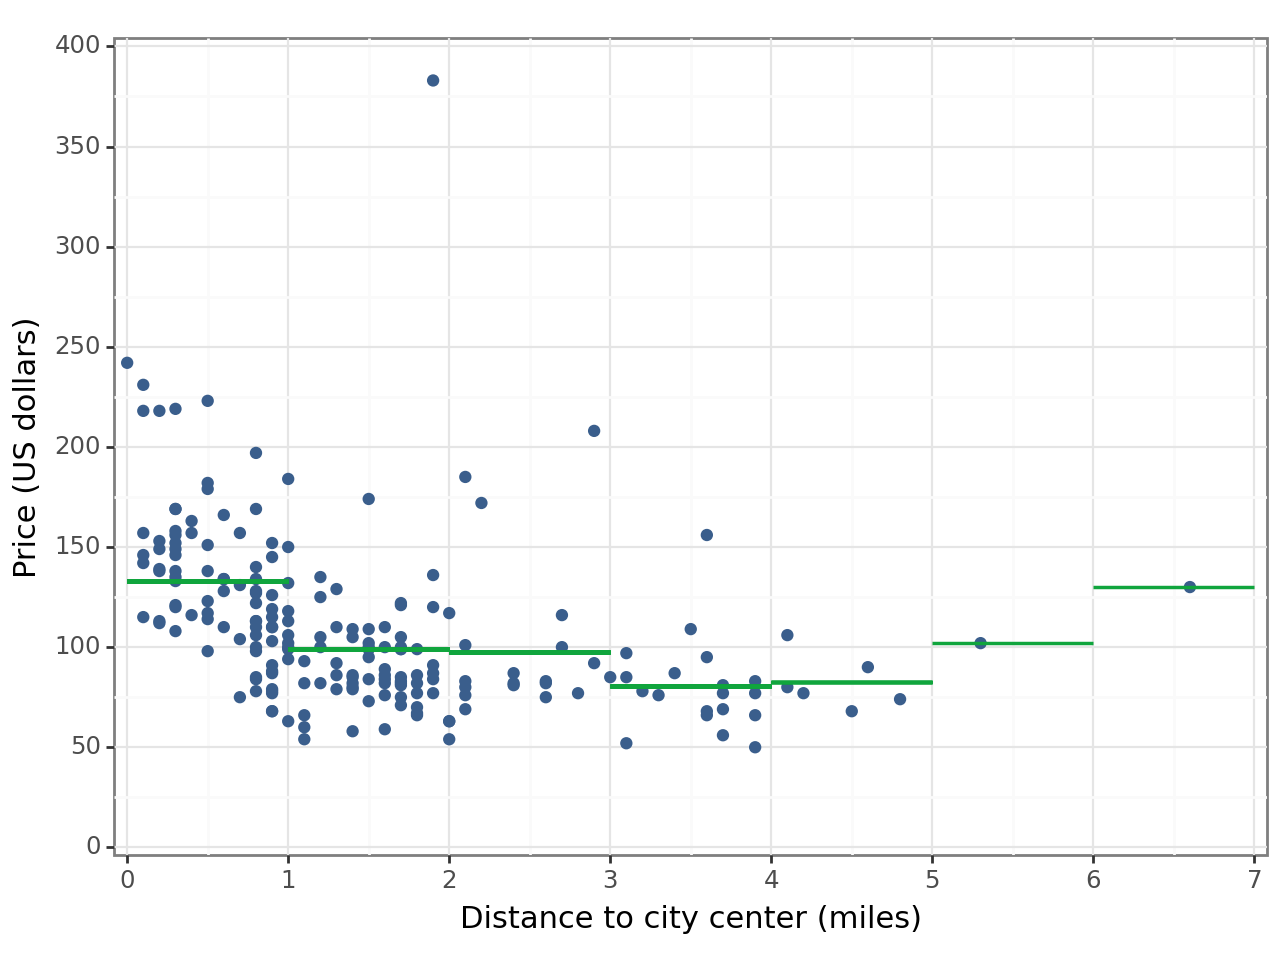

In [33]:
#add geom_segment
F07_2b = p1 + geom_segment(
    hotels,
    aes(x="dist7_s", y="yend", xend="xend", yend="yend"),
    color=color[1],
    size=0.7,
    na_rm=True,
)
print(F07_2b)


This regression looks non-monotonic, with flay parts in the middle and positive slope at the end.
There is more variation around the step function in the middle than towards the end.

When using bins, the number and size of bins may affect the patterns suggested by the non-parametric regressions.

### Figure 7.3
### LOWESS NONPARAMETRIC REGRESSION

**Smoothed conditional means plots**: non-parametrics regression that shows conditional means, smoothed
**Lowess**: most widely used 
A smooth curve fit around a bin scatter.

Does not produce numbers that summarize the pattern, intepret in qualitative way.

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scikit-misc from https://files.pythonhosted.org/packages/97/1e/3aec0177c5568afaf93053f527a63bf862614ce8f4f1d578bb4f039529c6/scikit_misc-0.3.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.0 MB 26.2 MB/s eta 0:00:01
   ---------- ----------------------------- 2.6/10.0 MB 32.3 MB/s eta 0:00:01
   ----------------- ---------------------- 4.4/10.0 MB 35.4 MB/s eta 0:00:01
   ----------------------- ---------------- 5.8/10.0 MB 33.6 MB/s eta 0:00:01
   ---------------------------- ----------- 7.0/10.0 MB 31.9 MB/s eta 0:00:01
   ---------------------------------- ----- 8.7/10.0 MB 32.6 MB/s eta 0:00:01
   ----------------------------------- ---- 8.9/10.0 MB 31.6 MB/s eta 0:00:01
   ------------------------------------- -- 9.3/10.0 MB 25.8 MB/s eta 0:00:01
   ---------

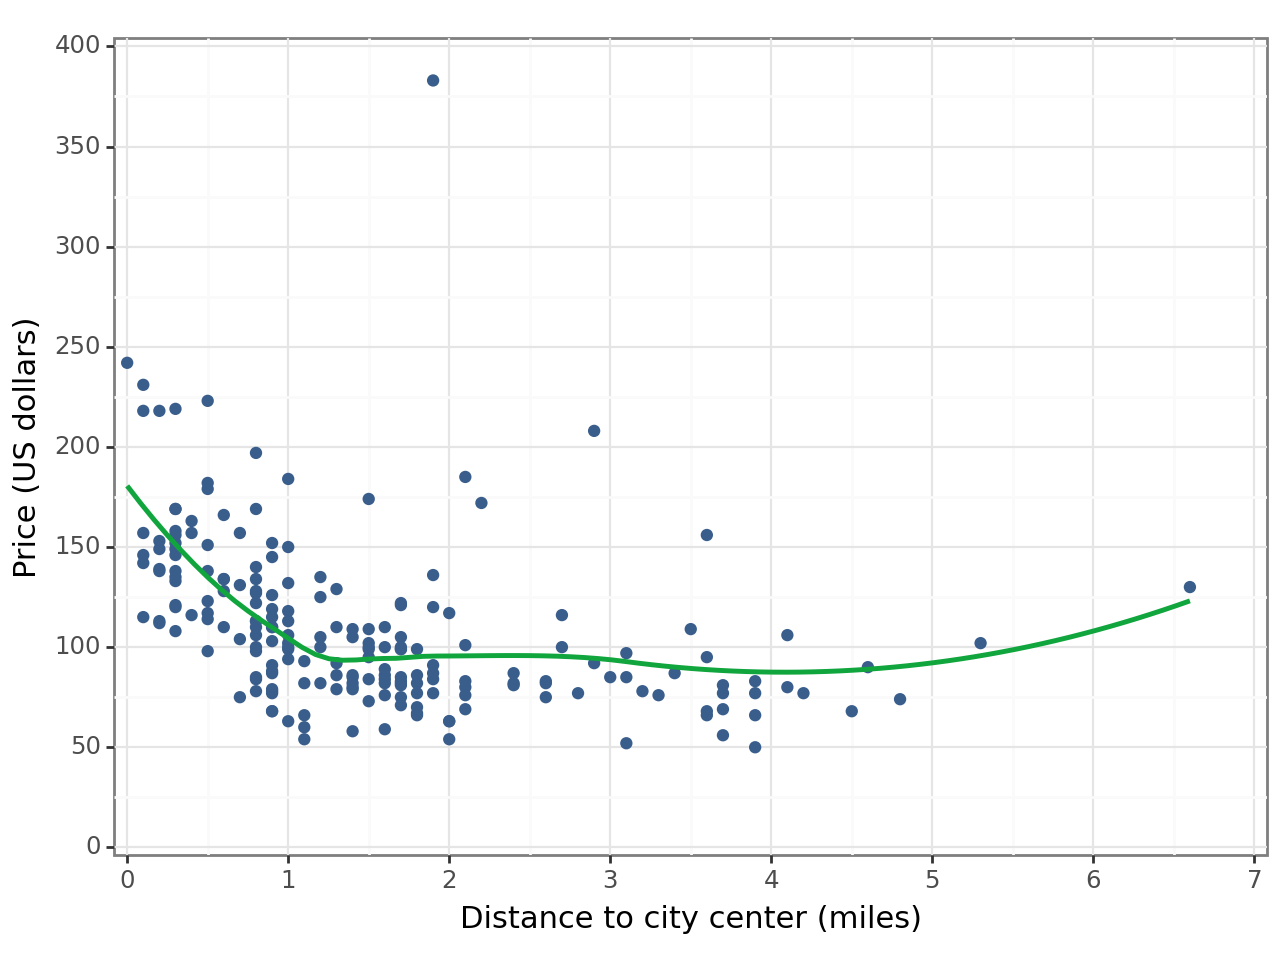

In [36]:
#add geom_smooth
!pip install scikit-misc
F07_3 = p1 + geom_smooth(method="loess", color=color[1], se=False)
print(F07_3)


Default band-width is 0.8 miles (close to the 1 mile bin width).
It retains some aspects of the bin scatter with seven bins: steeper at small distances, flatter at longer distances, turns positive at longest distances
But it is a smoother version

- Advantage: smooth curve which represent the pattern of association pretty flexibly!
- Disadvantage: no measurable properties: it smooth over the observations with an 'optimal' bandwidth.

The most robust pattern we uncovered across the various non-parametric regressions is a **negative slope** in general (most of the hotels fit this pattern). Thus, hotels further away from the city center are, **on average**,less expensive. But how much less expensive? We do not have yet a quantitave answer, we need linear regression.

# Linear regressions

Simple linear regression show the average of the dependent variable y as a linear function of the explanatory variable x:

$y^E = \alpha + \beta x$

We assume linearity in the coefficients

The resulting line is the **linear approximation** of the underlying $y^E=f(x)$, which can take any form 

=> $y^E = \alpha + \beta x$ fits a line through $y^E=f(x)$

=> by fitting the line, we approximate the the average slope of the $y^E=f(x)$ curve

**Conditional means**

$E[y|x] = \alpha + \beta x$
- $\alpha$ is the intercept (average value of y when x=0)
- $\beta$ is the slope (y is $\beta$ units higher, on average, for observations with one unit higher value of x)


## OLS
$\alpha$ and $\beta$ are the general coefficients that can be **estimated** using data

$\hat\beta = \frac{Cov[x,y]}{Var[x]} = \frac{\frac{1}{n}\sum_{i=1}^{n}(x_i -\bar{x})(y_i - \bar{y})}{\frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})^2}$ 

$\hat\alpha = \bar{y} - \hat\beta \bar{x}$ (note: point of average x and average y belongs to the regression line; can manipulate $\bar{y} = \hat\alpha + \hat\beta \bar{x})$

The calculated $\hat\alpha$ and $\hat\beta$ are called **OLS estimates**

The formulas used for calculating these are called **OLS estimators**

**OLS** gives the **best-fitting linear regression line**




The **OLS predicted values** of y are the implied values, i.e. those given, for each i, by $\hat{y}_i=\hat\alpha + \hat\beta x_i$ 

(best guess of average y for a value of x)

(points of the regression line $\ne$ non-parametric)

(can predict values of y for any x, even outside the data)

The **OLS residuals**, for each i, are the difference between the actual y values (from the data) and their predicted values $\hat{y}$

$e_i = y_i - \hat{y}_i$

(can be computed only for observations in the data)

(sum to zero with OLS -> average is 0 
-> 
$\bar{\hat{y}} =\bar{y}$)

The OLS method finds values of the coefficients of the linear regression that **minimize the difference between actual and implied values**

$\min_{\alpha,\beta} \sum_{i=1}^{n} (y_i - \alpha - \beta x_i)^2$

where $\hat\alpha$ and $\hat\beta$ are the solution to this minimization


For now, in regression table look at 
- intercept
- slope
- $R^2$ (reviewed later)

We use statsmodels.formula.api (smf) with .ols

In [41]:
### LINEAR REGRESSIONS
regression = smf.ols(formula="price~distance", data=hotels).fit()
regression.summary()
# regression.summary(slim=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           3.39e-09
Time:                        16:40:31   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.000     123.197     140.837
distance     -14.4064      2.331     -6.181      0.000     -19.002      -9.811
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear regression of hotel prices on distance (**y on x**) gives $\hat\alpha = 133$ and $\hat\beta = -14$:
- the average price of hotels in the city center (distance=0) is 133 dollars (note there is no such hotel in the data, because distance 0 corresponds to a church in our data)
- hotels that are **1 mile further away** from the city center are, **on average**, **14 dollars cheaper** (negative relation)

$price = 133 -14*distance$

### Figure 7.5
### SCATTERPLOT + REGRESSION LINE

We add to the scatter plot the regression line.

Linear regressions fit a straight line, thus by design, it cannot capture the convex nonlinear pattern suggested by the non-parametric regressions

But from a first look, not too bad

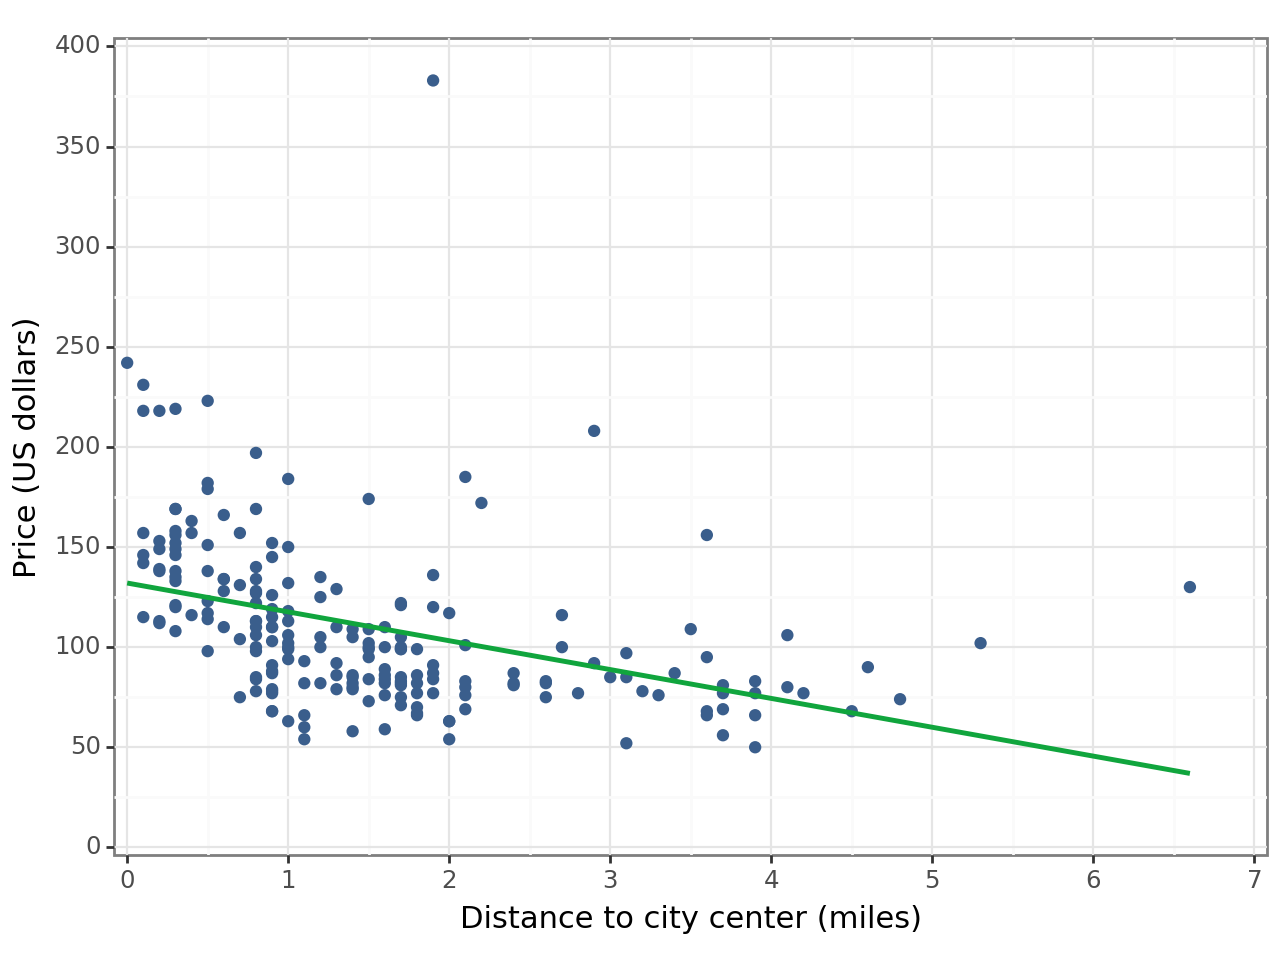

In [38]:
F07_5 = p1 + geom_smooth(method="lm", color=color[1], se=False)
print(F07_5)


### THE LINEAR REGRESSION GOES THROUGH THE AVERAGES
### SCATTERPLOT + REGRESSION LINE + LINES FOR AVERAGES (NOT in BOOK)

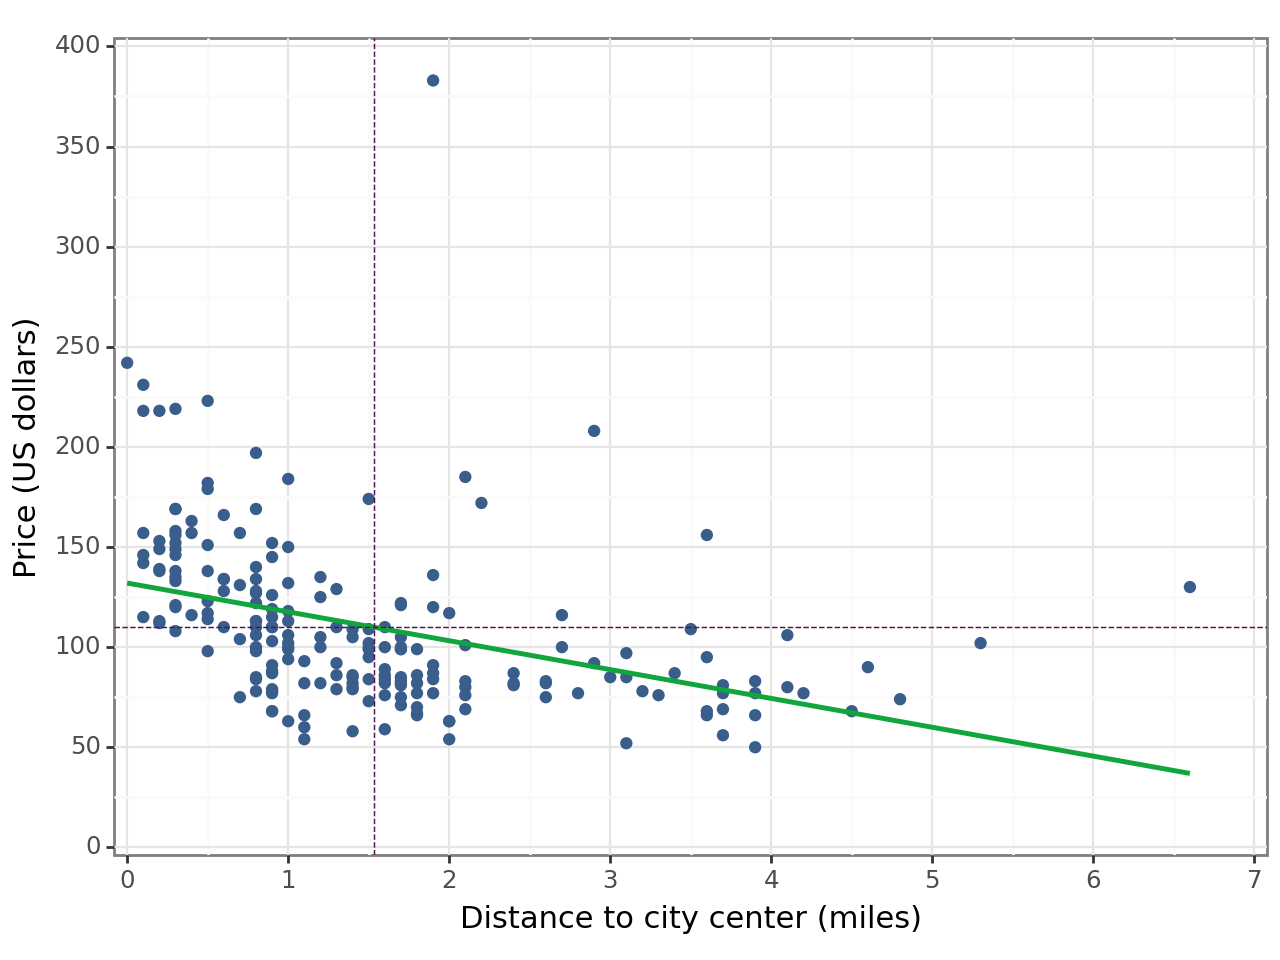

In [39]:
F07_x5 = (
    p1
    + geom_smooth(method="lm", color=color[1], se=False)
    + geom_vline(
        xintercept=hotels["distance"].mean(),
        color=color[2],
        linetype="dashed",
        size=0.3,
    )
    + geom_hline(
        yintercept=hotels["price"].mean(), color=color[2], linetype="dashed", size=0.3
    )
)
print(F07_x5)


### PREDICTED VALUES & RESIDUALS OF LINEAR REGRESSION 

In [42]:
regression = smf.ols(formula="price~distance", data=hotels).fit()
#same as before

Save the predicted values and residuals

In [43]:
hotels["predprice"] = regression.predict() #predicted values
hotels["e"] = regression.resid #residuals

### Figure 7.6, Table 7.1

Pick one observation, with distance = 2.9, and label the residual on the scatter plot

(In the scatterplot: the **regression line** shows the **predicted values**; the ***vertical distance*** of each point from the regression line is the ***residual*** corresponding to that observation)

In [44]:
xa = 2.9 # distance

get annotation values from the dataframe

In [45]:
ya = hotels.loc[hotels["distance"] == xa, "price"].values[0]
ym = hotels.loc[hotels["distance"] == xa, "predprice"].values[0]

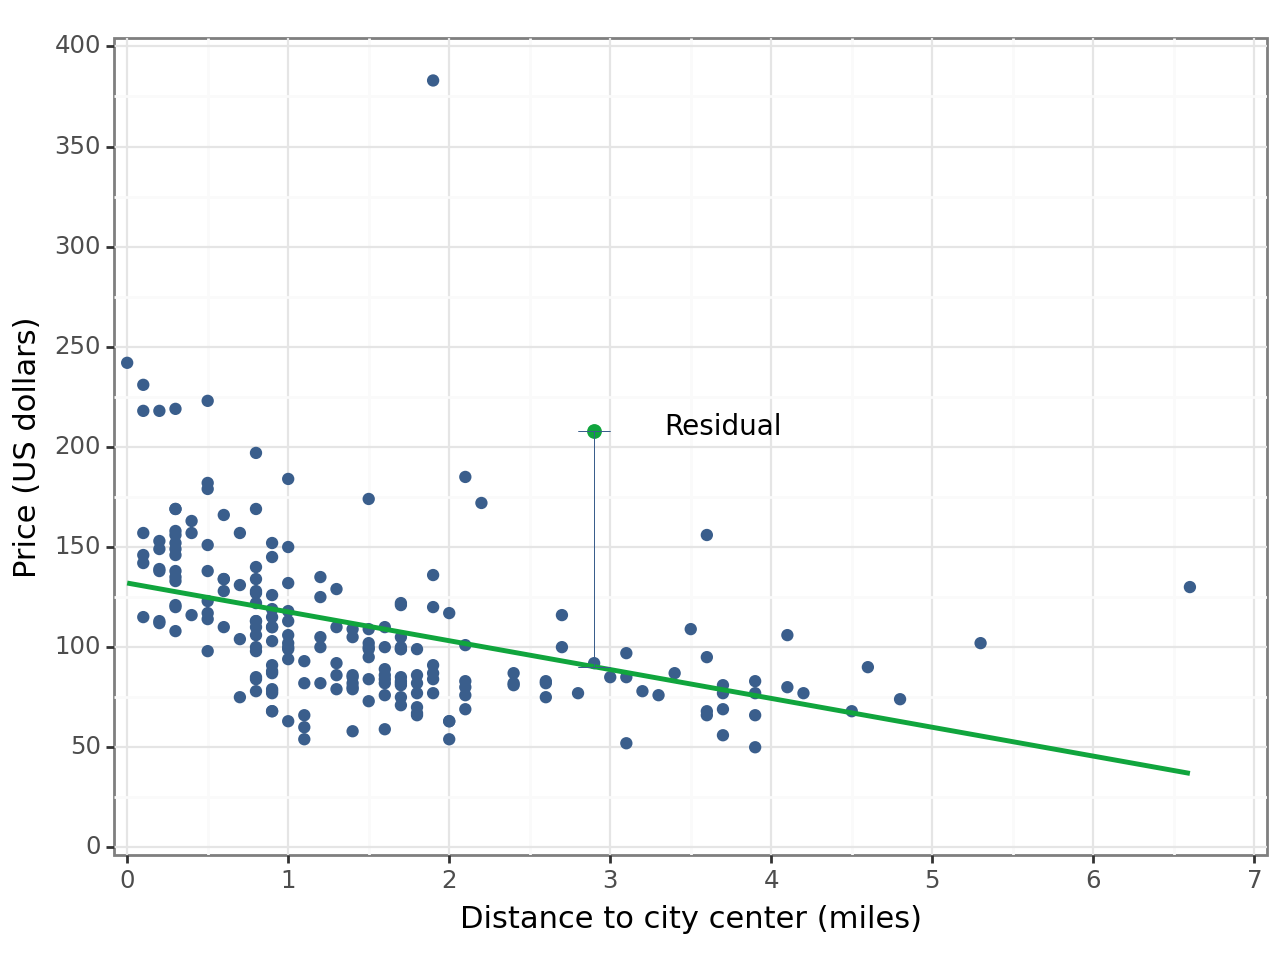

<Figure Size: (640 x 480)>

In [46]:
(
    p1
    + geom_smooth(method="lm", color=color[1], se=False)
    + annotate(
        "text",
        x=3.7,
        y=210,
        label="Residual",
        size=10,
    )
    + annotate("pointrange", x=xa, y=ya, ymin=ya, ymax=ya, color=color[1], size=0.5)
    + geom_errorbar(
        hotels.loc[hotels["distance"] == xa],
        aes(x="distance", ymin=ym, ymax=ya),
        width=0.2,
        size=0.2,
        color=color[0],
    )
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=seq(0, 7, by=1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 400, by=50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)

The plot shows the **positive residual** that we have selected: the price is above what predicted by the regression line

We want to show the distribution of the residuals. 

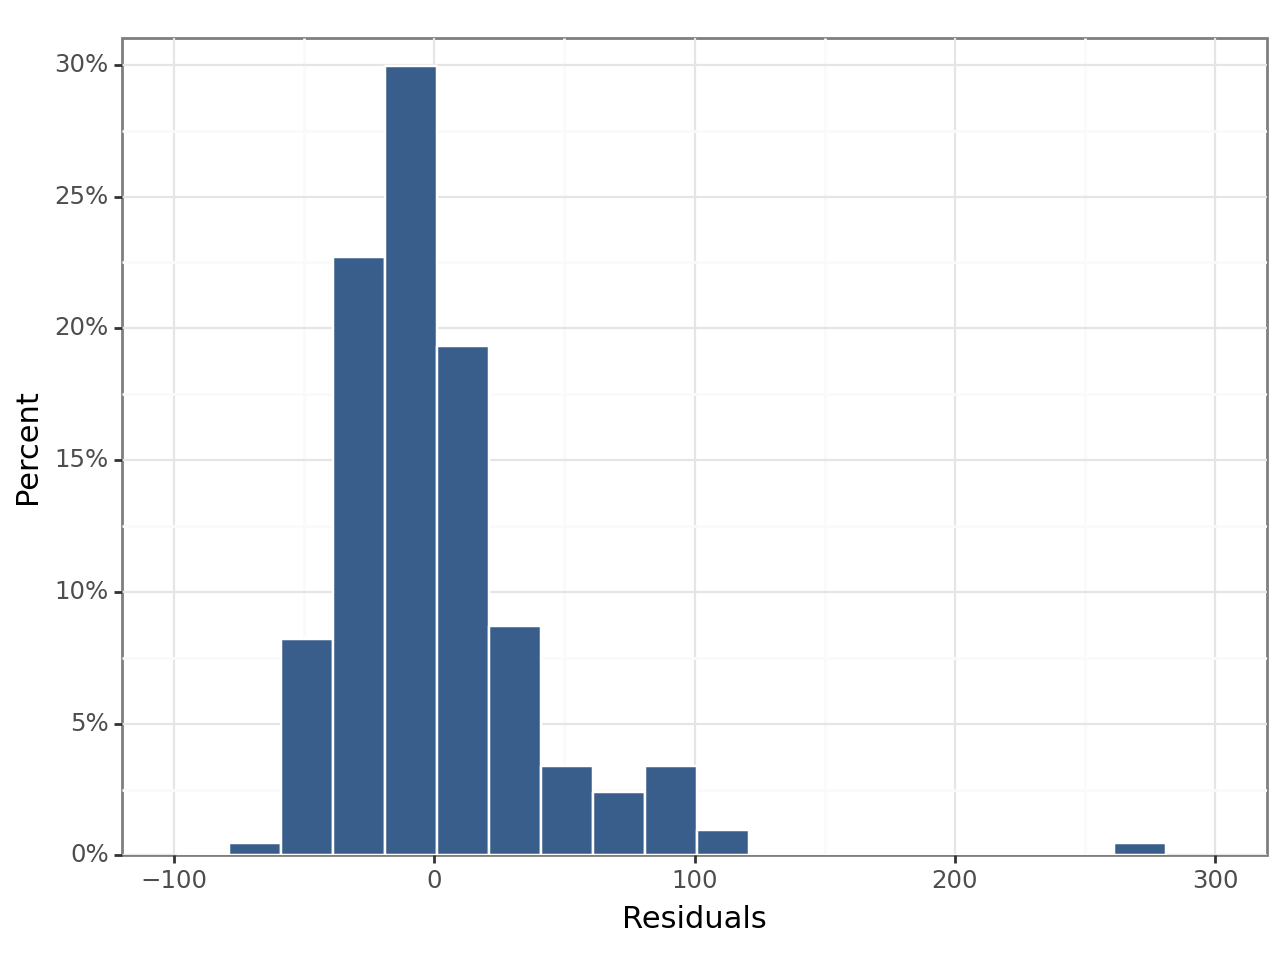

In [48]:
# histogram of residuals
F07_6a = (
    ggplot(hotels, aes(x="e"))
    + geom_histogram(
        aes(y="(..count..)/sum(..count..)"),
        binwidth=20,
        boundary=1,
        fill=color[0],
        color="white",
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Residuals", y="Percent")
    + scale_x_continuous(limits=(-100, 300), breaks=seq(-100, 300, by=100))
    + scale_y_continuous(
        expand=(0, 0),
        limits=(0, 0.31),
        breaks=seq(0, 0.31, by=0.05),
        labels=percent_format(),
    )
    + theme_bw()
)
print(F07_6a)


The distribution as **mean 0** but it is **skewed with a longer right-hand tail**: there are more hotels with a negative residual, but those residuals tend to be smaller than the positive ones.

The residuals help find an answer to the starting question: how to find a good deal (underpriced hotels relative to their location = lower price than expected)

Residuals = difference between actual price and expected price based on the regression

**The most underpriced** hotels are the ones with the **lowest, most negative residuals**

In [49]:
hotels["reg1_res"] = ["overpriced" if e >= 0 else "underpriced" for e in hotels["e"]]


In [50]:
hotels.loc[hotels["e"].sort_values().tail().index, "reg1_res"] = "top5"
hotels.loc[hotels["e"].sort_values().head().index, "reg1_res"] = "bottom5" 
#tail - most overpriced (top 5)
#head - most underpriced (bottom 5)


In [51]:
bestdeals = hotels.loc[hotels["e"].sort_values().head().index]

### Figure 7.7
### adding annotation

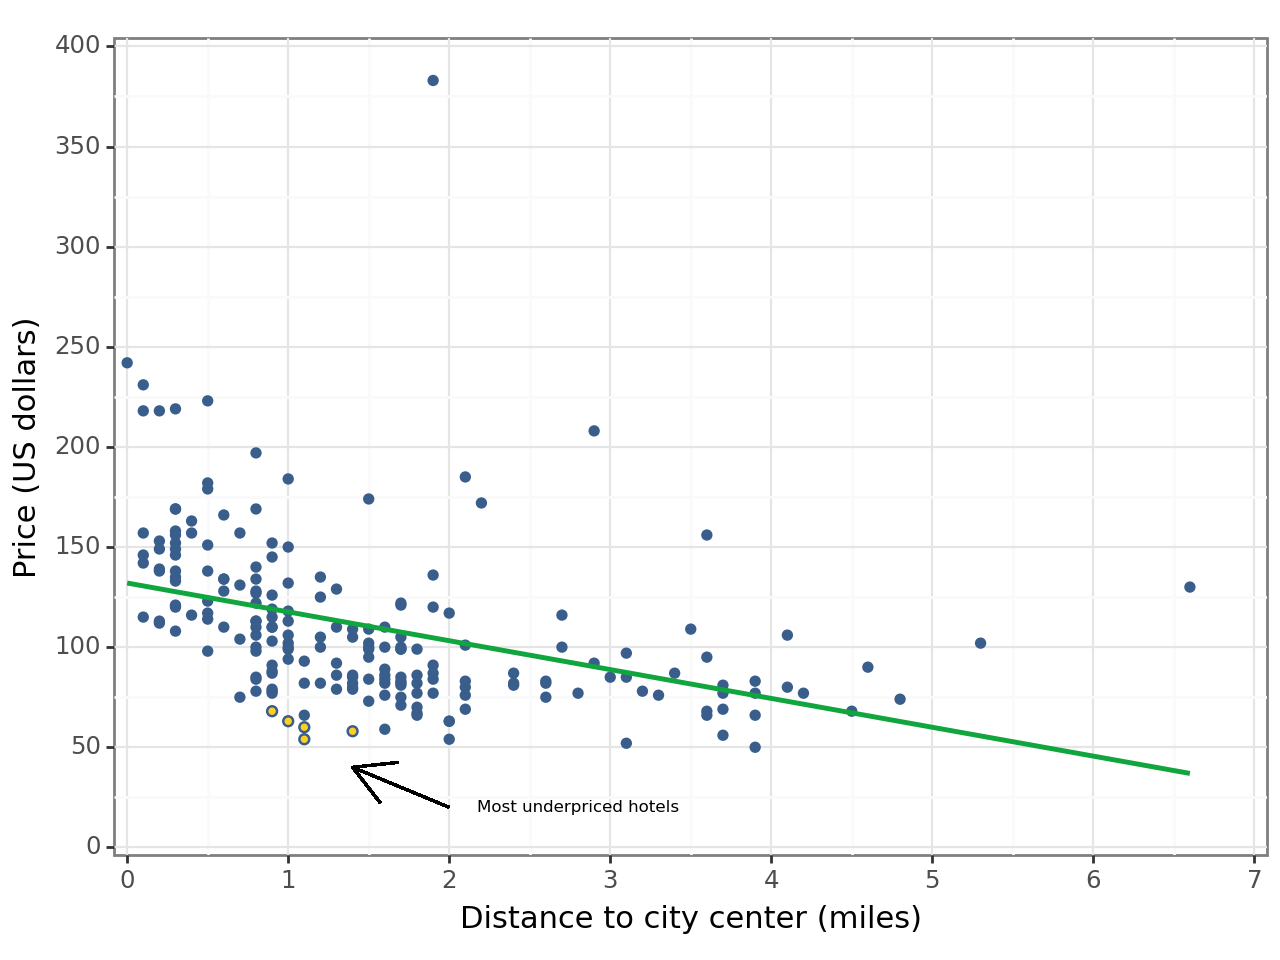

<Figure Size: (640 x 480)>

In [52]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    #add overpriced hotels (e=>0)
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "overpriced"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    #add underpriced hotels (e<0)
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "underpriced"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    #identify on the plot the most underpriced
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "bottom5"],
        aes(color="reg1_res", fill="reg1_res"),
        size=1.5,
        alpha=0.8,
        show_legend=False,
    )
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "top5"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    #add the regression line
    + geom_smooth(method="lm", size=1, color=color[1], se=False)
    + coord_cartesian(xlim=(0, 7), ylim=(0, 400))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 8), breaks=seq(0, 8, by=1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, by=50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + scale_color_manual(name="", values=(color[0], color[0], color[0], color[0]))
    + scale_fill_manual(name="", values=color[3])
    + annotate("text", x=2.8, y=20, label="Most underpriced hotels", size=6)
    + geom_segment(aes(x=2, y=20, xend=1.4, yend=40), arrow=arrow())
    + theme_bw()
)


### Table 7.1

Show the list of hotels with the five lowest values of the residual

In [54]:
(
    hotels.loc[
        hotels["reg1_res"] == "bottom5",
        ["hotel_id", "distance", "price", "predprice", "e"],
    ]
    .sort_values(by=["e"])
    .round(2)
    .reset_index(drop=True)
    .rename({"e": "residual"}, axis=1)
)

,hotel_id,distance,price,predprice,residual
0,22080,1.1,54,116.17,-62.17
1,21912,1.1,60,116.17,-56.17
2,22152,1.0,63,117.61,-54.61
3,22408,1.4,58,111.85,-53.85
4,22090,0.9,68,119.05,-51.05


If we thought that the simple linear regression estimated gave good prediction and good residuals, we would be done.

However, it is suspicious that this list of best candidates includes hotels that are around 1 mile from the center. This appears to be a consequence of fitting a line on a nonlinear pattern.

## Goodness of fit

**Fit of a regression**: how close the predicted y values ($\hat{y}_i$) are to the actual y values

$R^2$: measure of fit (calculates how much of the variation in y is captured by the regression and how much is left for residual variation)

$R^2 = \frac{Var[\hat{y}}{Var[y]} = 1-\frac{Var[e]}{Var[y]}$

(decomposition of total variation of y $Var[y]=Var[\hat{y}]+Var[e]$)

$0\le R^2 \le 1$ 

$R^2=0$ -> $\hat{y}_i=\bar{y}_i$ $\forall i$ (horizontal line, we cannot do better than the average)

Fit depends on 
- how well the model does in capturing the actual function $f$ ($y^E=f(x)$) -> modeling
- how far the actual values of y are spread around what would be predicted using the actual $f$ -> quality of data

We mostly care about $R^2$ when we aim at predicting

In [55]:
regression = smf.ols(formula="price~distance", data=hotels).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           3.39e-09
Time:                        17:00:43   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.000     123.197     140.837
distance     -14.4064      2.331     -6.181      0.000     -19.002      -9.811
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2 = 16\%$ - out of the overall variation in hotel prices, 16\% is **explained** by our linear regression; the remaining 84\% is left unexplained

### Correlation and linear regression

$\hat\beta = \frac{Cov[y,x]}{Var[x]}=Corr[x,y]\frac{Std[y]}{Std[x]}$

$R^2 = (Corr[x,y])^2$

Thus $R^2$ is another measure of association between x and y

### Regression and causation

Slope of -14: does this imply that longer distances **cause** hotels to be cheaper? **NO**